# QuantumOptics.jl

Website: https://qojulia.org/

Github repository: https://github.com/qojulia/QuantumOptics.jl

Documentation: https://qojulia.org/documentation/ ([Tutorial section](https://qojulia.org/documentation/tutorial.html#Tutorial-1))

[Publication](https://www.sciencedirect.com/science/article/pii/S0010465518300328?via%3Dihub), [Examples](https://github.com/qojulia/QuantumOptics.jl-examples), and [Benchmarks](https://qojulia.org/benchmarks)

`QuantumOptics.jl` is a numerical framework written in Julia that makes it easy to simulate various kinds of quantum systems. It is similar to the `Quantum Optics Toolbox` for MATLAB and its Python successor `QuTiP`.

Among others supports

* Combined quantum systems (e.g. two-level atom coupled to cavity or many particle system)
* Time evolution (Schrödinger and Master equation)

The [Tutorial](https://qojulia.org/documentation/tutorial.html#Tutorial-1) is a good starting point.

## Example: Particle in a harmonic trap

### Eigenstates

In [137]:
using QuantumOptics

basis = PositionBasis(-2, 2, 200)
x = position(basis)
p = momentum(basis)
H = p^2/4 + 2*(x^2)
energies, states = eigenstates((H+dagger(H))/2, 5);

In [139]:
typeof(states)

Array{Ket,1}

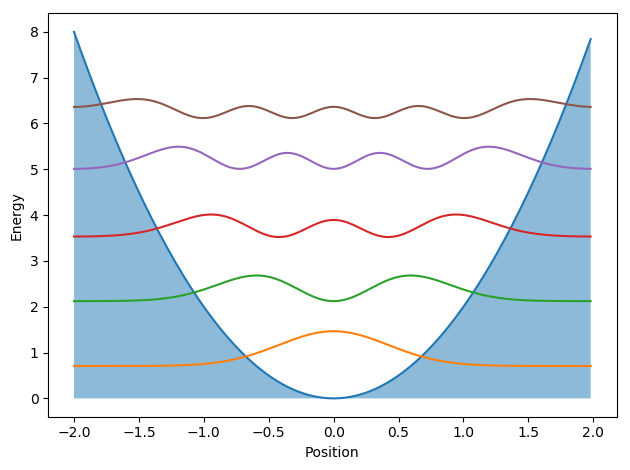

In [141]:
# Plotting
using PyPlot
xpoints = samplepoints(basis)
plot(xpoints, 2*xpoints.^2)
fill_between(xpoints, 0., 2*xpoints.^2, alpha=0.5)
for i=1:length(states)
    plot(xpoints, abs2.(states[i].data)*40 .+ energies[i])
end
xlabel("Position")
ylabel("Energy")
tight_layout()

### Time evolution

See https://qojulia.org/documentation/examples/particle-in-harmonic-trap.html

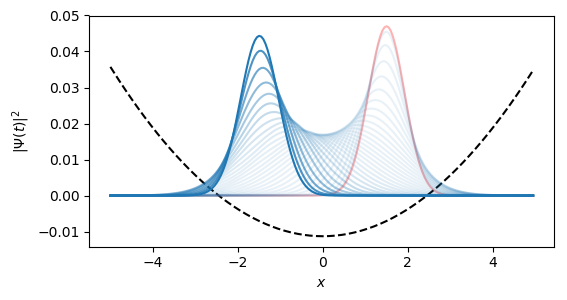

In [143]:
# System Parameters
m = 1.
ω = 0.5 # Strength of trapping potential;

# Position Basis
xmin = -5
xmax = 5
Npoints = 200
b_position = PositionBasis(xmin, xmax, Npoints)

# Hamiltonian in real space basis
p = momentum(b_position) # Dense operator
x = position(b_position) # Sparse operator

H = p^2/2m + 1/2*m*ω^2*dense(x^2);

b_momentum = MomentumBasis(b_position);

# Hamiltonian
p = momentum(b_momentum) # Sparse operator
x = position(b_momentum) # Dense operator

H = dense(p^2)/2m + 1/2*m*ω^2*x^2;

# Transforms a state multiplied from the right side from real space
# to momentum space.
T_px = particle.transform(b_momentum, b_position);

T_xp = dagger(T_px)

x = position(b_position)
p = momentum(b_momentum)

H_kin = LazyProduct(T_xp, p^2/2m, T_px)
V = ω*x^2
H = LazySum(H_kin, V);

# Initial state
x0 = 1.5
p0 = 0
sigma0 = 0.6
Ψ0 = gaussianstate(b_position, x0, p0, sigma0);

# Time evolution
T = [0:0.1:3;]
tout, Ψt = timeevolution.schroedinger(T, Ψ0, H);

# Plot dynamics of particle density
x_points = particle.samplepoints(b_position)

n = abs.(Ψ0.data).^2
V = ω*x_points.^2
C = maximum(V)/maximum(n)

figure(figsize=(6,3))
xlabel(L"x")
ylabel(L"| \Psi(t) |^2")
plot(x_points, (V.-3)./C, "k--")

for i=1:length(T)
    Ψ = Ψt[i]
    n .= abs.(Ψ.data).^2
    if i == 1
        plot(x_points, n, "red", alpha=0.9*(float(i)/length(T))^8+0.3)
    else
        plot(x_points, n, "C0", alpha=0.9*(float(i)/length(T))^8+0.1)
    end
end
show()

# Example: Gaussian particle running against a potential barrier

See https://qojulia.org/documentation/examples/particle-into-barrier.html

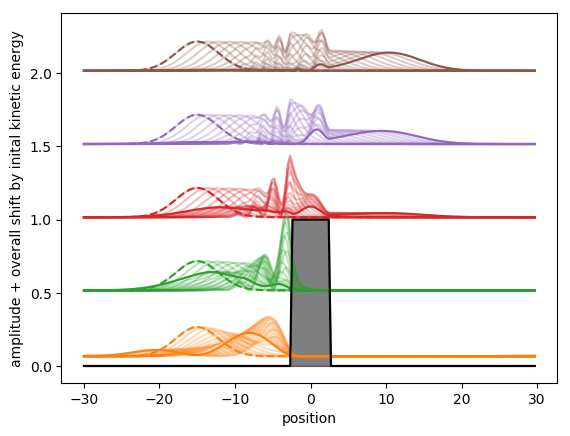

In [156]:
xmin = -30
xmax = 30
Npoints = 200

b_position = PositionBasis(xmin, xmax, Npoints)
b_momentum = MomentumBasis(b_position);

V0 = 1. # Height of Barrier
d = 5 # Width of Barrier
function V_barrier(x)
    if x < -d/2 || x > d/2
        return 0.
    else
        return V0
    end
end
V = potentialoperator(b_position, V_barrier);

Txp = transform(b_position, b_momentum)
Tpx = transform(b_momentum, b_position)
Hkin = LazyProduct(Txp, momentum(b_momentum)^2/2, Tpx);
H = LazySum(Hkin, V);

xpoints = samplepoints(b_position)

x0 = -15
sigma0 = 4
p0vec = [sqrt(0.1), 1, sqrt(2), sqrt(3), 2]
timecuts = 20

for i_p in 1:length(p0vec)
    p0 = p0vec[i_p]
    Ψ₀ = gaussianstate(b_position, x0, p0, sigma0)
    scaling = 1.0/maximum(abs.(Ψ₀.data))^2/5
    n0 = abs.(Ψ₀.data).^2 .* scaling

    tmax = 2*abs(x0)/(p0+0.2)
    T = collect(range(0.0, stop=tmax, length=timecuts))
    tout, Ψt = timeevolution.schroedinger(T, Ψ₀, H);

    offset = real.(expect(Hkin, Ψ₀))
    plot(xpoints, n0.+offset, "C$i_p--")
    for i=1:length(T)
        Ψ = Ψt[i]
        n = abs.(Ψ.data).^2 .* scaling
        plot(xpoints, n.+offset, "C$i_p", alpha=0.3)
    end
    nt = abs.(Ψt[timecuts].data).^2*scaling
    plot(xpoints, nt.+offset, "C$i_p")
end
y = V_barrier.(xpoints)
fill_between(xpoints, 0, y, color="k", alpha=0.5);
plot(xpoints, y, "k")
xlabel("position")
ylabel("amplitude + overall shift by inital kinetic energy")
show()